#### Imports

In [ ]:
from environments import build_blue_agent, build_red_agent, sample

import ray
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from time import sleep

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
import logging
logging.disable(logging.WARNING)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
logger = logging.getLogger(__name__)


#### Verify GPU

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)

#### Train Competitive Blue Agent

In [ ]:
tolerance = 4 # number of batches without improvement before ending training
generations = 100

# Create Initial Policies
ray.init(ignore_reinit_error=True, log_to_driver=False)
blue = build_blue_agent()
red = build_red_agent(opponent=True)

blue_scores = []
red_scores = []

print()
print("+---------------------------------+")
print("| Blue Competitive Training Start |")
print("+---------------------------------+")
print()

for g in range(1, generations+1):

    if (g < 10):
        dashes = 14
    elif (g < 100):
        dashes = 15
    else:
        dashes = 16
    print('+'+'-'*dashes+'+')            
    print(f"| Generation {g} |")
    print('+'+'-'*dashes+'+')
    print()

    blue.restore("./policies/blue_competitive_pool/competitive_blue_0/checkpoint_000000")

    b = 0 # b tracks the batches of training completed
    blue_min = float('inf')
    tol = tolerance
    while True:
        b += 1
        result = blue.train()
        blue_score = -result["sampler_results"]["episode_reward_mean"]
        entropy = result['info']['learner']['default_policy']['learner_stats']['entropy']
        vf_loss = result['info']['learner']['default_policy']['learner_stats']['vf_loss']
        print(f"Batch {b} -- Blue Score: {blue_score:0.2f}    Entropy: {entropy:0.2f}    VF Loss: {vf_loss:0.2f}") 
        if b > 1:
            if (blue_score < blue_min):
                blue_min = blue_score
                tol = tolerance
                checkpoint_path = blue.save(checkpoint_dir=f"./policies/blue_competitive_pool/competitive_blue_{g}")
                path_file = open(f"./policies/blue_competitive_pool/competitive_blue_{g}/checkpoint_path", "w")
                path_file.write(checkpoint_path)
                path_file.close()
            elif(tol > 1):
                tol -= 1
            # when agent is no longer improving, break and save the new competitive agent
            else:
                blue_scores.append(blue_min)
                blue.restore(checkpoint_path)
                print(checkpoint_path)
                break

    pool_size = g
    pool_file = open("./policies/blue_competitive_pool/pool_size", "w")
    pool_file.write(str(pool_size))
    pool_file.close()
    print()

    red.restore("./policies/red_opponent_pool/opponent_red_0/checkpoint_000000")

    b = 0
    red_max = 0
    tol = tolerance
    while True:
        b += 1
        result = red.train()
        red_score = result["sampler_results"]["episode_reward_mean"]
        entropy = result['info']['learner']['default_policy']['learner_stats']['entropy']
        vf_loss = result['info']['learner']['default_policy']['learner_stats']['vf_loss']
        print(f"Batch {b} -- Red Score: {red_score:0.2f}    Entropy: {entropy:0.2f}    VF_loss: {vf_loss:0.2f}")
        if b > 1:
            if (red_score > red_max):
                red_max = red_score
                tol = tolerance
                checkpoint_path = red.save(checkpoint_dir=f"./policies/red_opponent_pool/opponent_red_{g}")   
                path_file = open(f"./policies/red_opponent_pool/opponent_red_{g}/checkpoint_path", "w")
                path_file.write(checkpoint_path)
                path_file.close()
            elif(tol > 1):
                tol -= 1
             # when agent is no longer improving, break and save the new best-response agent
            else:
                red_scores.append(red_max)
                red.restore(checkpoint_path)
                print(checkpoint_path)
                break

    pool_file = open("./policies/red_opponent_pool/pool_size", "w")
    pool_file.write(str(pool_size))
    pool_file.close()
    print()

    print(f'Blue Scores so far {["%.2f" % i for i in blue_scores]}')
    print(f'Red Scores so far {["%.2f" % i for i in red_scores]}')
    print()
    
    print(f'-------- Sample Game for Generation {g} --------')
    sample(red, blue, verbose=True, show_policy=True)
    print()

#### Evaluate Blue MinMax Performance

In [ ]:
b_max = [0]*(generations+1) # blue agent maximum scores
b_max_op = [0]*(generations+1) # id of red opponent that got max score
b_best_score = float('inf')
b_best_id = 0

# evaluate existing pool of agents
print('Evaluating Agents...')
# iteration through blue agents
for b in range(generations,0,-1):
    path_file = open(f"./policies/blue_competitive_pool/competitive_blue_{b}/checkpoint_path", "r")
    blue_restore_path = path_file.read()
    path_file.close()
    blue.restore(blue_restore_path)

    # iterate through red agents
    for r in range(generations,0,-1):
        path_file = open(f"./policies/red_opponent_pool/opponent_red_{r}/checkpoint_path", "r")
        red_restore_path = path_file.read()
        path_file.close()
        red.restore(red_restore_path)

        score = sample(red, blue, games=50)
        if score > b_max[b]:
            b_max[b] = score
            b_max_op[b] = r
    
    print(f'Blue Agent {b} allows a maximum of {b_max[b]:0.2f} points, against Red Opponent {b_max_op[b]}.')
    if b_max[b] < b_best_score:
        b_best_score = b_max[b]
        b_best_id = b

print()
print(f'Top performing Blue Agent is generation {b_best_id}')

path_file = open(f"./policies/blue_competitive_pool/competitive_blue_{b_best_id}/checkpoint_path", "r")
blue_competitive_path = path_file.read()
path_file.close()
path_file = open("./policies/competitive_blue_policy", "w")
path_file.write(blue_competitive_path)
path_file.close()

ray.shutdown()

In [8]:
b_exp = [] # exploitability of each Blue Policy
for b in b_max[1:]:
    b_exp.append(b-b_best_score)
print(b_exp)

[37.622, 3.977999999999999, 3.95, 3.1260000000000003, 1.3579999999999997, 1.4459999999999997, 1.4659999999999993, 1.33, 1.42, 1.3019999999999996, 6.757999999999998, 1.4779999999999998, 1.3779999999999992, 1.4419999999999993, 1.476, 1.476, 1.1139999999999999, 1.4159999999999995, 1.3379999999999992, 1.4079999999999995, 1.2399999999999993, 1.4479999999999995, 1.3479999999999999, 1.3419999999999996, 1.4099999999999993, 1.3099999999999996, 1.4059999999999997, 1.4159999999999995, 1.1519999999999992, 1.2859999999999996, 1.4019999999999992, 0.8860000000000001, 4.087999999999998, 1.1919999999999993, 1.3319999999999999, 1.0699999999999994, 1.3259999999999996, 0.8140000000000001, 0.9119999999999999, 0.9319999999999995, 1.2719999999999994, 0.5839999999999996, 1.4159999999999995, 0.9319999999999995, 1.3699999999999992, 0.694, 0.6459999999999999, 0.726, 1.056, 0.96, 1.4299999999999997, 0.33199999999999985, 0.9559999999999995, 0.7679999999999998, 1.0579999999999998, 0.2859999999999996, 0.487999999999

#### Plot Blue Training Scores

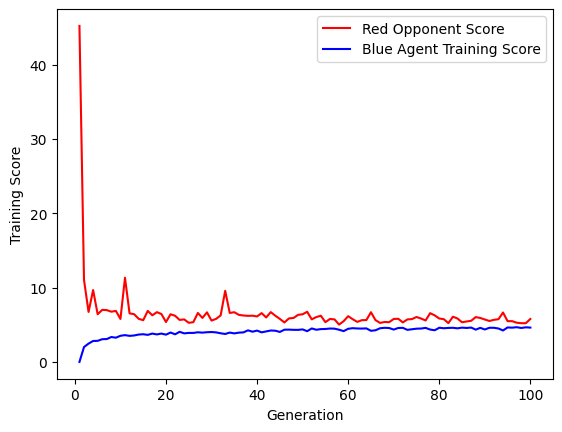

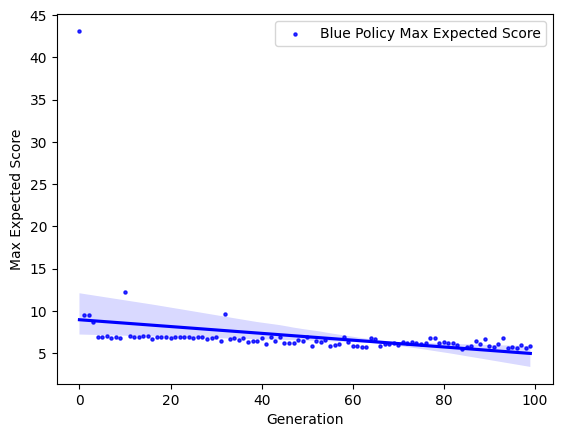

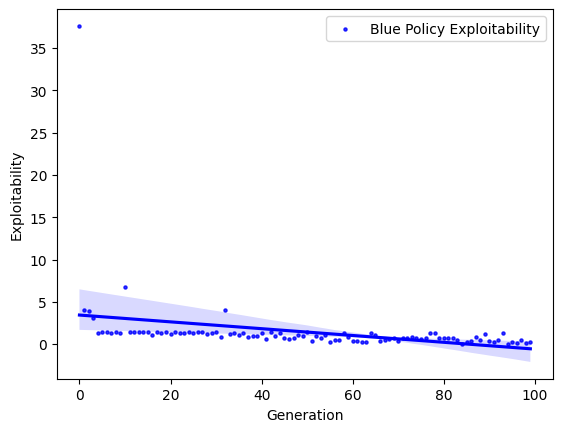

In [9]:
# Scores During Training
id_plot = [id for id in range(1,len(red_scores)+1)]
data_plot = pd.DataFrame({"Generation":id_plot, "Training Score":red_scores, "Blue Scores":blue_scores})
plt.figure()
sns.lineplot(x = "Generation", y = "Training Score", data=data_plot, color='red', label="Red Opponent Score")
sns.lineplot(x = "Generation", y = "Blue Scores", data=data_plot, color='blue', label="Blue Agent Training Score")
plt.show()

# Minmax Evaluation
id_plot = [id for id in range(len(red_scores))]
data_plot = pd.DataFrame({"Generation":id_plot, "Max Expected Score":b_max[1:]})
plt.figure()
#sns.regplot(x = "Generation", y = "MinMax Score", data=data_plot, color='red', scatter_kws={'s':5})
sns.regplot(x = "Generation", y = "Max Expected Score", data=data_plot, color='blue', scatter_kws={'s':5}, label="Blue Policy Max Expected Score")
plt.legend()
plt.show()

# Exploitability
id_plot = [id for id in range(len(red_scores))]
data_plot = pd.DataFrame({"Generation":id_plot, "Exploitability":b_exp})
plt.figure()
sns.regplot(x = "Generation", y = "Exploitability", data=data_plot, color='blue', scatter_kws={'s':5}, label="Blue Policy Exploitability")
plt.legend()
plt.show()

Dropping first five data points

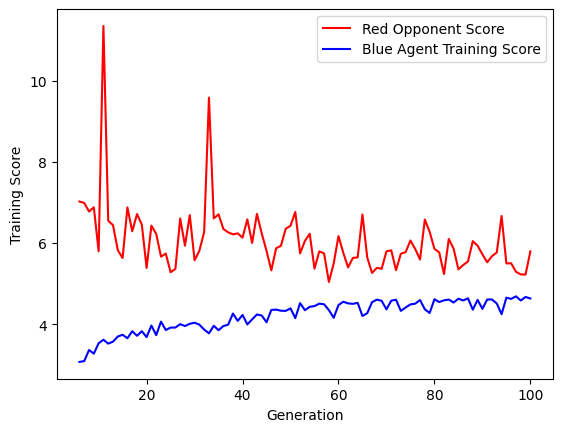

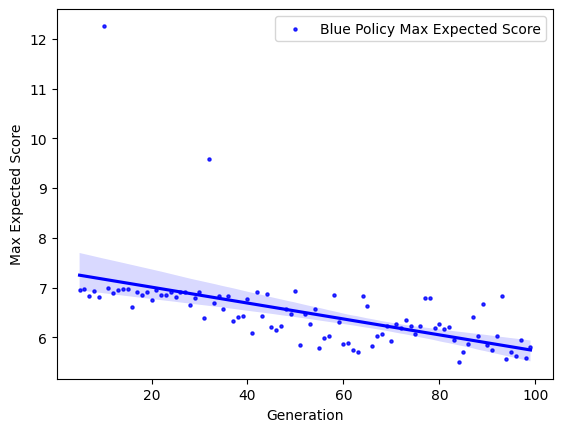

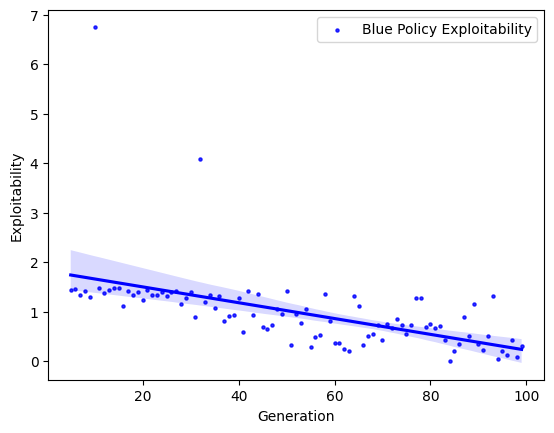

In [10]:
# Scores During Training
id_plot = [id for id in range(1,len(red_scores)+1)]
data_plot = pd.DataFrame({"Generation":id_plot[5:], "Training Score":red_scores[5:], "Blue Scores":blue_scores[5:]})
plt.figure()
sns.lineplot(x = "Generation", y = "Training Score", data=data_plot, color='red', label="Red Opponent Score")
sns.lineplot(x = "Generation", y = "Blue Scores", data=data_plot, color='blue', label="Blue Agent Training Score")
plt.show()

# Minmax Evaluation
id_plot = [id for id in range(len(red_scores))]
data_plot = pd.DataFrame({"Generation":id_plot[5:], "Max Expected Score":b_max[6:]})
plt.figure()
sns.regplot(x = "Generation", y = "Max Expected Score", data=data_plot, color='blue', scatter_kws={'s':5}, label="Blue Policy Max Expected Score")
plt.legend()
plt.show()

# Exploitability
id_plot = [id for id in range(len(red_scores))]
data_plot = pd.DataFrame({"Generation":id_plot[5:], "Exploitability":b_exp[5:]})
plt.figure()
sns.regplot(x = "Generation", y = "Exploitability", data=data_plot, color='blue', scatter_kws={'s':5}, label="Blue Policy Exploitability")
plt.legend()
plt.show()

#### Train Competitive Red Agent

In [ ]:
tolerance = 4 # number of batches without improvement before ending training
generations = 100

# Create Initial Policies
ray.init(ignore_reinit_error=True, log_to_driver=False)
blue = build_blue_agent(opponent=True)
red = build_red_agent()

blue_scores = []
red_scores = []

print()
print("+--------------------------------+")
print("| Red Competitive Training Start |")
print("+--------------------------------+")
print()

for g in range(1, generations+1):

    if (g < 10):
        dashes = 14
    elif (g < 100):
        dashes = 15
    else:
        dashes = 16
    print('+'+'-'*dashes+'+')            
    print(f"| Generation {g} |")
    print('+'+'-'*dashes+'+')
    print()

    red.restore("./policies/red_competitive_pool/competitive_red_0/checkpoint_000000")

    b = 0
    red_max = 0
    tol = tolerance
    while True:
        b += 1
        result = red.train()
        red_score = result["sampler_results"]["episode_reward_mean"]
        entropy = result['info']['learner']['default_policy']['learner_stats']['entropy']
        vf_loss = result['info']['learner']['default_policy']['learner_stats']['vf_loss']
        print(f"Batch {b} -- Red Score: {red_score:0.2f}    Entropy: {entropy:0.2f}    VF_loss: {vf_loss:0.2f}")
        if b > 1:
            if (red_score > red_max):
                red_max = red_score
                tol = tolerance
                checkpoint_path = red.save(checkpoint_dir=f"./policies/red_competitive_pool/competitive_red_{g}")   
                path_file = open(f"./policies/red_competitive_pool/competitive_red_{g}/checkpoint_path", "w")
                path_file.write(checkpoint_path)
                path_file.close()
            elif(tol > 1):
                tol -= 1
             # when agent is no longer improving, break and save the new best-response agent
            else:
                red_scores.append(red_max)
                red.restore(checkpoint_path)
                print(checkpoint_path)
                break

    pool_size = g
    pool_file = open("./policies/red_competitive_pool/pool_size", "w")
    pool_file.write(str(pool_size))
    pool_file.close()
    print()

    blue.restore("./policies/blue_opponent_pool/opponent_blue_0/checkpoint_000000")

    b = 0 # b tracks the batches of training completed
    blue_min = float('inf')
    tol = tolerance
    while True:
        b += 1
        result = blue.train()
        blue_score = -result["sampler_results"]["episode_reward_mean"]
        entropy = result['info']['learner']['default_policy']['learner_stats']['entropy']
        vf_loss = result['info']['learner']['default_policy']['learner_stats']['vf_loss']
        print(f"Batch {b} -- Blue Score: {blue_score:0.2f}    Entropy: {entropy:0.2f}    VF Loss: {vf_loss:0.2f}") 
        if b > 1:
            if (blue_score < blue_min):
                blue_min = blue_score
                tol = tolerance
                checkpoint_path = blue.save(checkpoint_dir=f"./policies/blue_opponent_pool/opponent_blue_{g}")
                path_file = open(f"./policies/blue_opponent_pool/opponent_blue_{g}/checkpoint_path", "w")
                path_file.write(checkpoint_path)
                path_file.close()
            elif(tol > 1):
                tol -= 1
            # when agent is no longer improving, break and save the new competitive agent
            else:
                blue_scores.append(blue_min)
                blue.restore(checkpoint_path)
                print(checkpoint_path)
                break

    pool_file = open("./policies/blue_opponent_pool/pool_size", "w")
    pool_file.write(str(pool_size))
    pool_file.close()
    print()

    print(f'Blue Scores so far {["%.2f" % i for i in blue_scores]}')
    print(f'Red Scores so far {["%.2f" % i for i in red_scores]}')
    print()
    
    print(f'-------- Sample Game for Generation {g} --------')
    sample(red, blue, verbose=True, show_policy=True)
    print()

#### Evaluate Red MinMax Performance

In [ ]:
r_min = [float('inf')]*(generations+1) # red agent minimum scores
r_min_op = [0]*(generations+1) # id of blue opponent that got max score
r_best_score = 0
r_best_id = 0

# evaluate existing pool of agents
print('Evaluating Agents...')
# iteration through red agents
for r in range(generations,0,-1):
    path_file = open(f"./policies/red_competitive_pool/competitive_red_{r}/checkpoint_path", "r")
    red_restore_path = path_file.read()
    path_file.close()
    red.restore(red_restore_path)

    # iterate through blue opponents
    for b in range(generations,0,-1):
        path_file = open(f"./policies/blue_opponent_pool/opponent_blue_{b}/checkpoint_path", "r")
        blue_restore_path = path_file.read()
        path_file.close()
        blue.restore(blue_restore_path)

        score = sample(red, blue, games=50)
        if score < r_min[r]:
            r_min[r] = score
            r_min_op[r] = b
    
    print(f'Red Agent {r} expects a minimum of {r_min[r]:0.2f} points, against Blue Opponent {r_min_op[r]}.')
    if r_min[r] > r_best_score:
        r_best_score = r_min[r]
        r_best_id = r


print()
print(f'Top performing Red Agent is generation {r_best_id}')

path_file = open(f"./policies/red_competitive_pool/competitive_red_{r_best_id}/checkpoint_path", "r")
red_competitive_path = path_file.read()
path_file.close()
path_file = open("./policies/competitive_red_policy", "w")
path_file.write(red_competitive_path)
path_file.close()

ray.shutdown()

In [16]:
r_exp = [] # exploitability of each Red Policy
for r in r_min[1:]:
    r_exp.append(r_best_score-r)
print(r_exp)

[2.034, 2.072, 2.8000000000000003, 2.7620000000000005, 1.7600000000000002, 1.19, 0.8679999999999999, 0.46799999999999997, 0.9299999999999997, 0.9359999999999995, 0.3099999999999996, 1.8960000000000004, 0.4979999999999998, 0.5679999999999996, 0.8160000000000003, 0.3620000000000001, 0.6379999999999995, 0.2519999999999998, 0.5780000000000003, 0.5059999999999998, 0.44599999999999973, 0.258, 0.5820000000000003, 0.7859999999999996, 0.6900000000000004, 0.6499999999999999, 0.3860000000000001, 0.3919999999999999, 0.7919999999999998, 0.778, 0.8559999999999994, 0.5779999999999998, 0.14400000000000013, 0.43999999999999995, 0.42799999999999994, 0.5899999999999999, 0.28200000000000003, 0.5179999999999998, 0.5879999999999996, 0.794, 0.6299999999999999, 0.6659999999999995, 1.008, 0.30600000000000005, 0.3959999999999999, 0.6159999999999997, 0.4700000000000002, 0.49599999999999955, 0.6600000000000001, 0.6659999999999999, 0.6819999999999999, 0.7960000000000003, 0.266, 0.6099999999999999, 0.31400000000000

#### Plot Red Training Scores

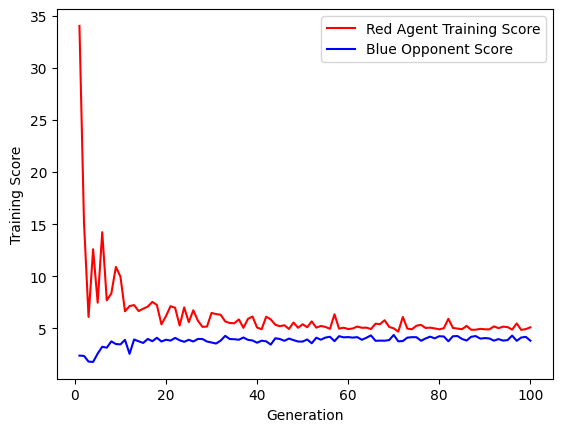

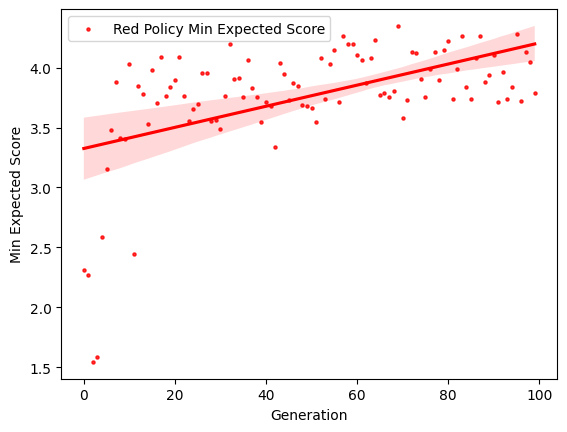

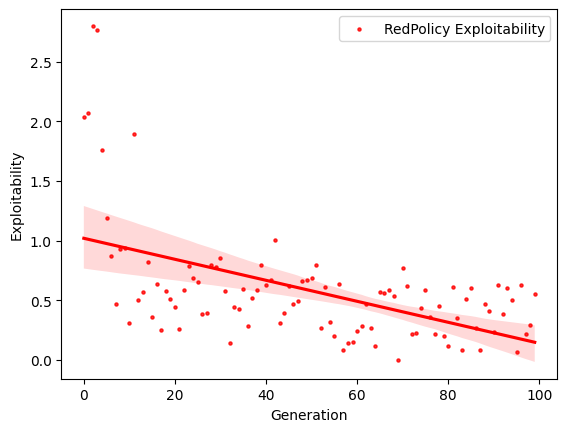

In [19]:
# Scores During Training
id_plot = [id for id in range(1,len(red_scores)+1)]
data_plot = pd.DataFrame({"Generation":id_plot, "Training Score":red_scores, "Blue Scores":blue_scores})
plt.figure()
sns.lineplot(x = "Generation", y = "Training Score", data=data_plot, color='red', label="Red Agent Training Score")
sns.lineplot(x = "Generation", y = "Blue Scores", data=data_plot, color='blue', label="Blue Opponent Score")
plt.show()

# Minmax Evaluation
id_plot = [id for id in range(len(red_scores))]
data_plot = pd.DataFrame({"Generation":id_plot, "Min Expected Score":r_min[1:]})
plt.figure()
sns.regplot(x = "Generation", y = "Min Expected Score", data=data_plot, color='red', scatter_kws={'s':5}, label="Red Policy Min Expected Score")
plt.legend()
plt.show()

# Exploitability
id_plot = [id for id in range(len(red_scores))]
data_plot = pd.DataFrame({"Generation":id_plot, "Exploitability":r_exp})
plt.figure()
sns.regplot(x = "Generation", y = "Exploitability", data=data_plot, color='red', scatter_kws={'s':5}, label="RedPolicy Exploitability")
plt.legend()
plt.show()

Dropping first five data points

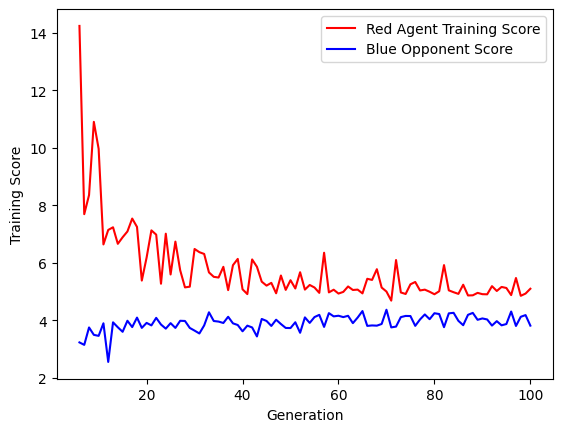

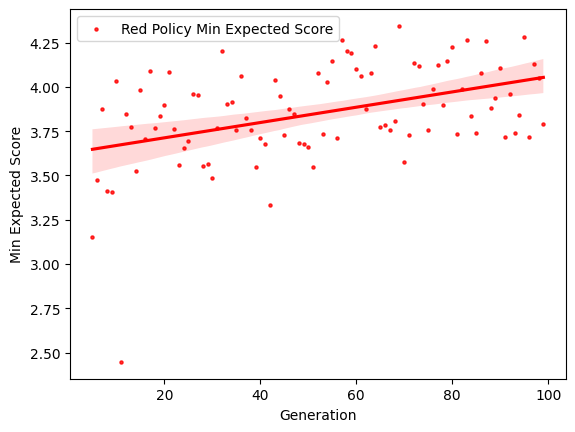

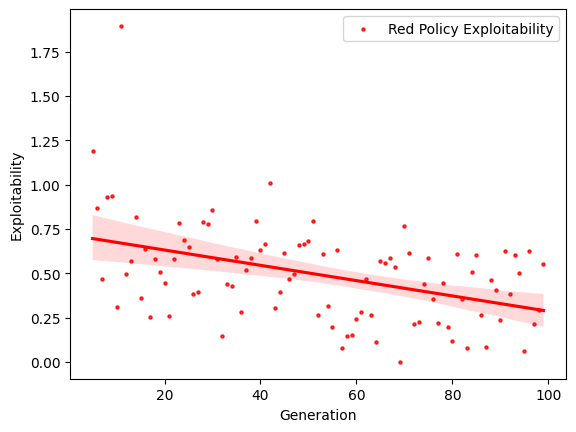

In [18]:
# Scores During Training
id_plot = [id for id in range(1,len(red_scores)+1)]
data_plot = pd.DataFrame({"Generation":id_plot[5:], "Training Score":red_scores[5:], "Blue Scores":blue_scores[5:]})
plt.figure()
sns.lineplot(x = "Generation", y = "Training Score", data=data_plot, color='red', label="Red Agent Training Score")
sns.lineplot(x = "Generation", y = "Blue Scores", data=data_plot, color='blue', label="Blue Opponent Score")
plt.show()

# Minmax Evaluation
id_plot = [id for id in range(len(red_scores))]
data_plot = pd.DataFrame({"Generation":id_plot[5:], "Min Expected Score":r_min[6:]})
plt.figure()
sns.regplot(x = "Generation", y = "Min Expected Score", data=data_plot, color='red', scatter_kws={'s':5}, label="Red Policy Min Expected Score")
plt.legend()
plt.show()

# Exploitability
id_plot = [id for id in range(len(red_scores))]
data_plot = pd.DataFrame({"Generation":id_plot[5:], "Exploitability":r_exp[5:]})
plt.figure()
sns.regplot(x = "Generation", y = "Exploitability", data=data_plot, color='red', scatter_kws={'s':5}, label="Red Policy Exploitability")
plt.legend()
plt.show()